**В задании предлагается с помощью визуального анализа ответить на несколько вопросов по данным о сердечно-сосудистых заболеваниях. Данные использовались в соревновании ML Boot Camp 5 (качать их не надо, они уже есть в репозитории).**

**Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в веб-форме. Код отправлять никуда не нужно.**

В соревновании предлагалось определить наличие/отсутствие сердечно-сосудистых заболеваний (ССЗ) по результатам осмотра пациента.

**Описание данных.**

Датасет сформирован из реальных клинических анализов, и в нём используются признаки, которые можно разбить на 3 группы:

Объективные признаки:

* Возраст (age)
* Рост (height)
* Вес (weight)
* Пол (gender)

Результаты измерения:

* Артериальное давление верхнее и нижнее (ap_hi, ap_lo)
* Холестерин (cholesterol)
* Глюкоза (gluc)
* Субъективные признаки (со слов пациентов):
* Курение (smoke)
* Употребление алкоголя (alco)
* Физическая активность (active)

Целевой признак (который интересно будет прогнозировать):

* Наличие сердечно-сосудистых заболеваний по результатам классического врачебного осмотра (cardio)

Возраст дан в днях. Значения показателей холестерина и глюкозы представлены одним из трех классов: норма, выше нормы, значительно выше нормы. Значения субъективных признаков — бинарны.

Все показатели даны на момент осмотра.

In [1]:
# подгружаем все нужные пакеты
import pandas as pd
import numpy as np

# игнорируем warnings
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
%matplotlib inline

# настройка внешнего вида графиков в seaborn
sns.set_context(
    "notebook", 
    font_scale = 1.5,       
    rc = { 
        "figure.figsize" : (12, 9), 
        "axes.titlesize" : 18 
    }
)

В рамках задания для простоты будем работать только с обучающей выборкой. Чистить данные от выбросов и ошибок в данных НЕ нужно, кроме тех случаев, где об этом явно указано. 

Все визуализации рекомендуем производить с помощью библиотеки Seaborn.

## Проведем небольшой EDA


In [2]:
train = pd.read_csv('mlbootcamp5_train.csv', sep=';',
                    index_col='id')

In [3]:
print('Размер датасета: ', train.shape)
train.head()

Размер датасета:  (70000, 12)


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Для начала всегда неплохо бы посмотреть на значения, которые принимают переменные.

Переведем данные в "Long Format"-представление и отрисуем с помощью factorplot количество значений, которые принимают категориальные переменные.

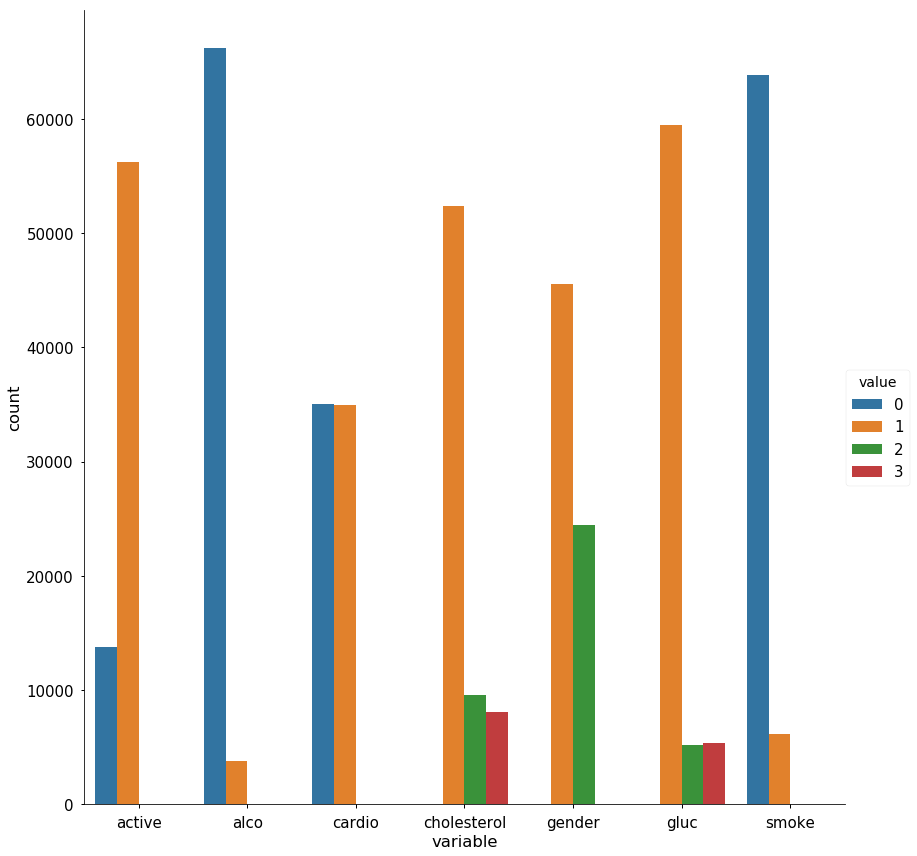

In [4]:
train_uniques = pd.melt(frame=train, value_vars=['gender','cholesterol', 
                                                 'gluc', 'smoke', 'alco', 
                                                 'active', 'cardio'])
train_uniques = pd.DataFrame(train_uniques.groupby(['variable', 
                                                    'value'])['value'].count()) \
    .sort_index(level=[0, 1]) \
    .rename(columns={'value': 'count'}) \
    .reset_index()
    
sns.factorplot(x='variable', y='count', hue='value', 
               data=train_uniques, kind='bar', size=12);

Видим, что классы целевой переменной cardio сбалансированы, отлично!

Можно также разбить элементы обучающей выборки по значениям целевой переменной: иногда на таких графиках можно сразу увидеть самый значимый признак.

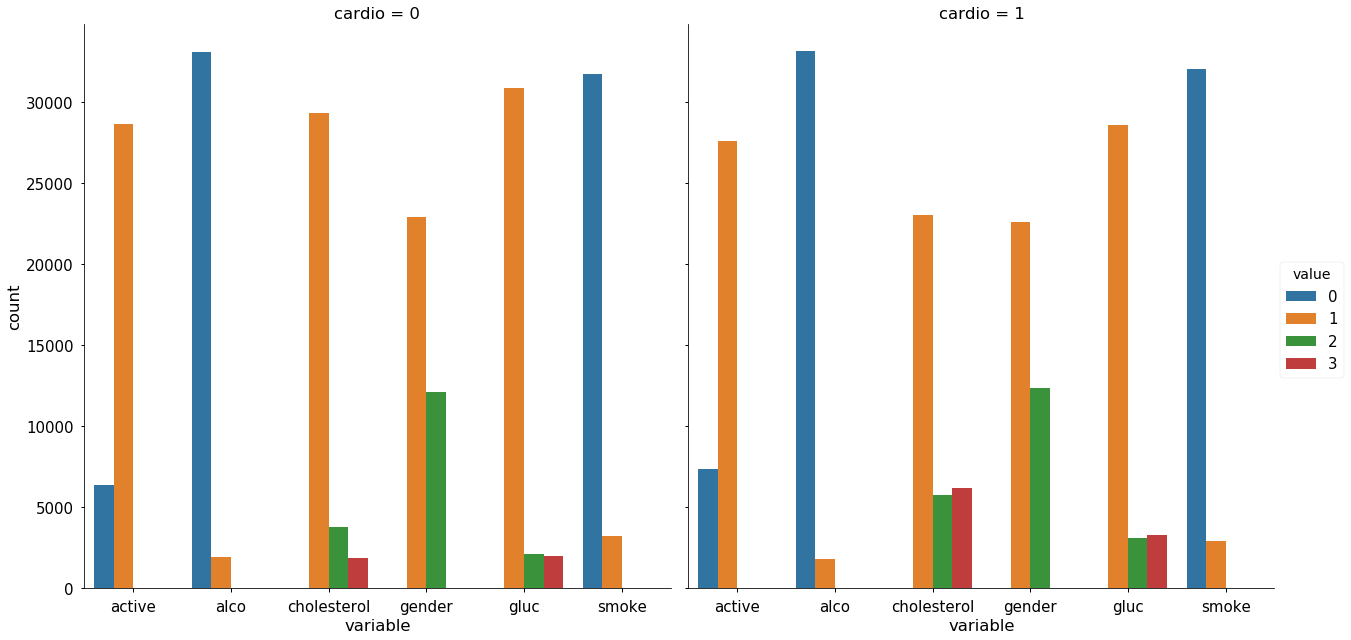

In [5]:
train_uniques = pd.melt(frame=train, value_vars=['gender','cholesterol', 
                                                 'gluc', 'smoke', 'alco', 
                                                 'active'], 
                        id_vars=['cardio'])
train_uniques = pd.DataFrame(train_uniques.groupby(['variable', 'value', 
                                                    'cardio'])['value'].count()) \
    .sort_index(level=[0, 1]) \
    .rename(columns={'value': 'count'}) \
    .reset_index()
    
sns.factorplot(x='variable', y='count', hue='value', 
               col='cardio', data=train_uniques, kind='bar', size=9);

Видим, что в зависимости от целевой переменной сильно меняется распределение холестерина и глюкозы. Совпадение?

** Немного статистики по уникальным значениям признаков. **

In [6]:
for c in train.columns:
    n = train[c].nunique()
    print(c)
    
    if n <= 3:
        print(n, sorted(train[c].value_counts().to_dict().items()))
    else:
        print(n)
    print(10 * '-')

age
8076
----------
gender
2 [(1, 45530), (2, 24470)]
----------
height
109
----------
weight
287
----------
ap_hi
153
----------
ap_lo
157
----------
cholesterol
3 [(1, 52385), (2, 9549), (3, 8066)]
----------
gluc
3 [(1, 59479), (2, 5190), (3, 5331)]
----------
smoke
2 [(0, 63831), (1, 6169)]
----------
alco
2 [(0, 66236), (1, 3764)]
----------
active
2 [(0, 13739), (1, 56261)]
----------
cardio
2 [(0, 35021), (1, 34979)]
----------


Итого:
    
* Пять количественных признаков (без id)
* Семь категориальных
* 70000 объектов


# 1. Визуализируем корреляционную матрицу

Для того чтобы лучше понять признаки в датасете, можно посчитать матрицу коэффициентов корреляции между признаками. 

Постройте heatmap корреляционной матрицы. Матрица формируется средствами Pandas, со стандартным значением параметров.

### 1. Какие два признака больше всего коррелируют (по Пирсону) с признаком height ?


* Gluc, Cholesterol
* Weight, Alco
* Smoke, Alco
* Weight, Gender

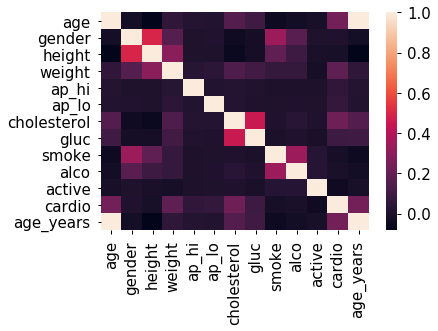

In [10]:
import seaborn as sns
corr = train.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

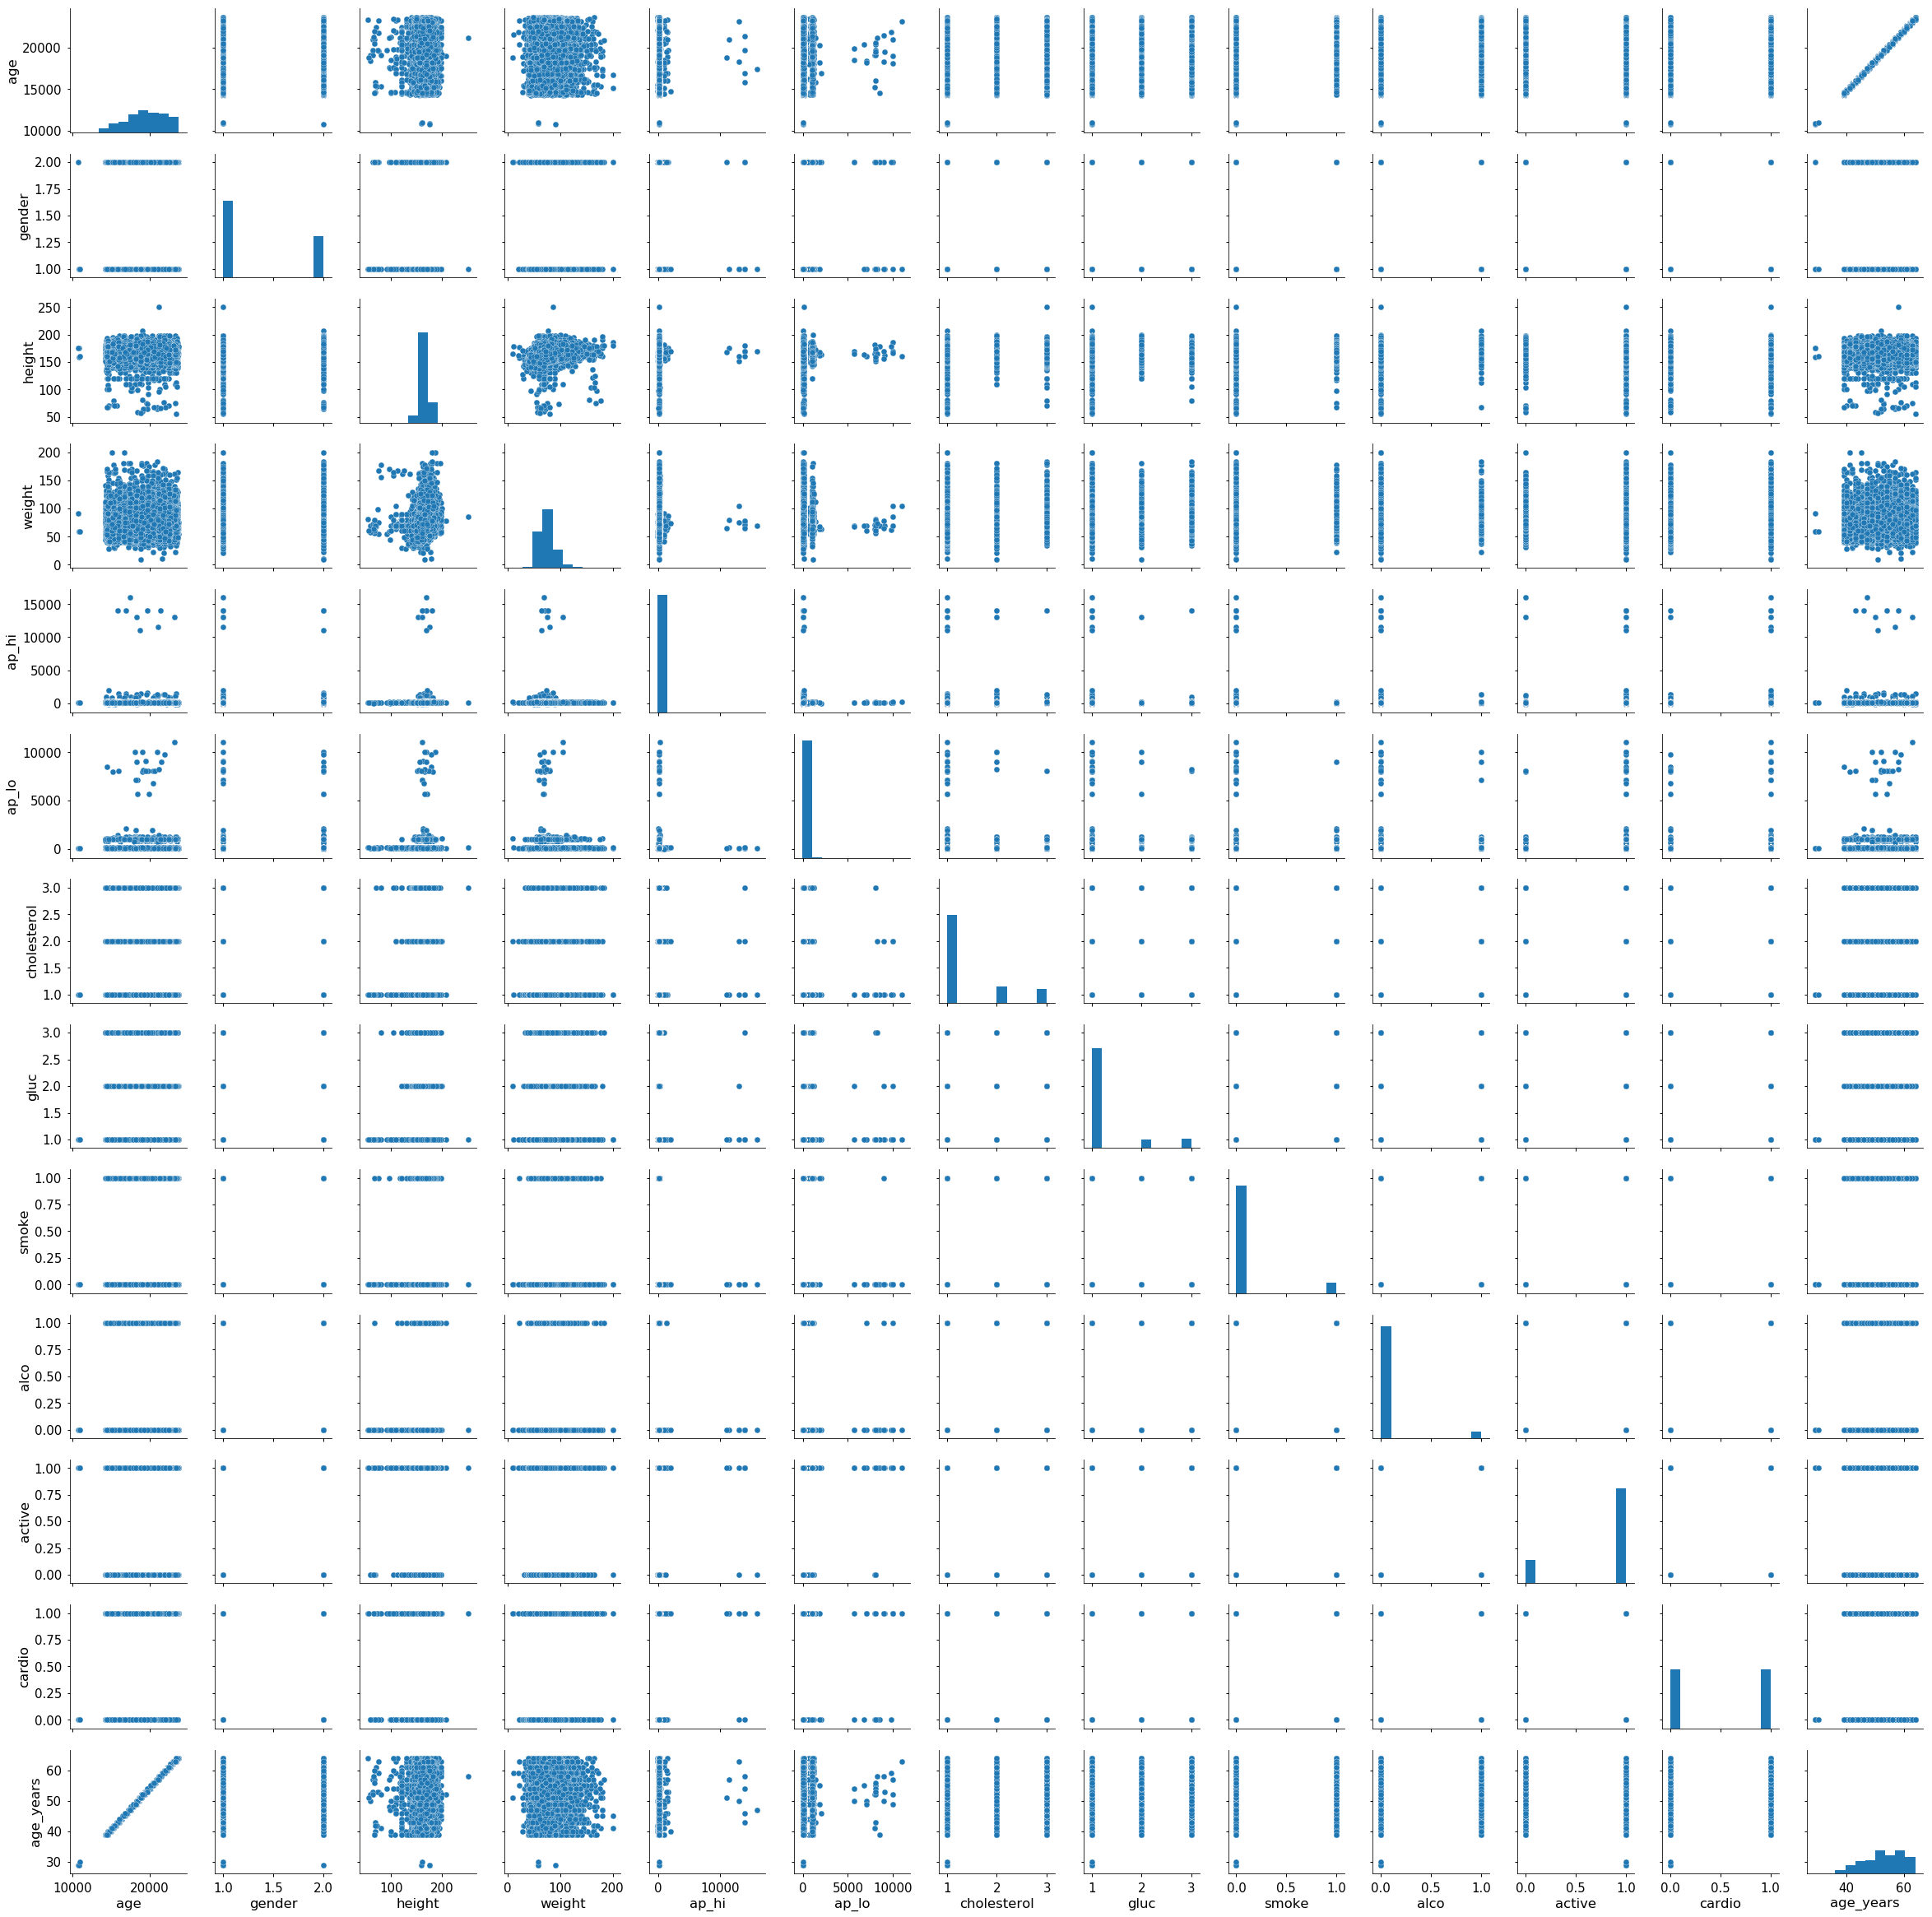

In [11]:
sns.pairplot(train)

In [17]:
train.corr().height

age           -0.081515
gender         0.499033
height         1.000000
weight         0.290968
ap_hi          0.005488
ap_lo          0.006150
cholesterol   -0.050226
gluc          -0.018595
smoke          0.187989
alco           0.094419
active        -0.006570
cardio        -0.010821
age_years     -0.081373
Name: height, dtype: float64

Weight, Gender

# 2. Распределение роста для мужчин и женщин

Как мы увидели, в процессе исследования уникальных значений пол кодируется значениями 1 и 2, расшифровка изначально не была нам дана в описании данных, но мы догадались, кто есть кто, посчитав средние значения роста (или веса) при разных значениях признака gender. Теперь сделаем то же самое, но графически.

Постройте violinplot для роста и пола. Используйте:

* hue – для разбивки по полу
* scale – для оценки количества каждого из полов 

Для корректной отрисовки, преобразуйте DataFrame в "Long Format"-представление с помощью функции melt в pandas. 
еще один пример

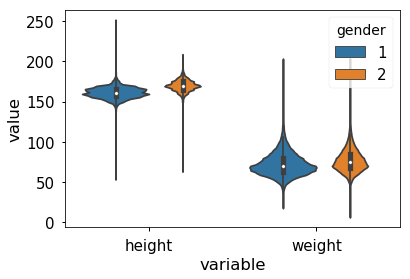

In [30]:
df = pd.melt(train, value_vars=['height', 'weight'], id_vars='gender')
sns.violinplot(x='variable', y='value', hue='gender', scale = 'count', data=df)
plt.show()


Постройте на одном графике два отдельных kdeplot роста, отдельно для мужчин и женщин. На нем разница будет более наглядной, но нельзя будет оценить количество мужчин/женщин.

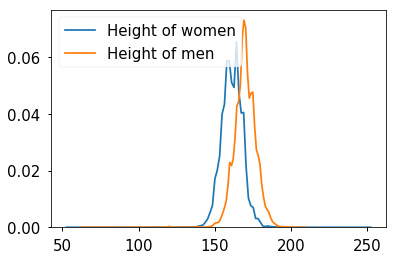

In [46]:
sns.kdeplot(train[train['gender']==1]['height'], label='Height of women')
sns.kdeplot(train[train['gender']==2]['height'], label='Height of men')

# 3. Ранговая корреляция


В большинстве случаев достаточно воспользоваться линейным коэффициентом корреляции Пирсона для выявления закономерностей в данных, но мы пойдём чуть дальше и используем ранговую корреляцию, которая поможет нам выявить пары, в которых меньший ранг из вариационного ряда одного признака всегда предшествует большему другого (или наоборот, в случае отрицательной корреляции).

**Постройте корреляционную матрицу, используя коэффициент Спирмена **

In [48]:
corrPearson = train.corr(method='spearman')
corrPearson

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years
age,1.000000,-0.020176,-0.082292,0.061559,0.219087,0.156700,0.140113,0.091791,-0.047471,-0.030078,-0.010422,0.234429,0.999013
gender,-0.020176,1.000000,0.533805,0.172480,0.063174,0.066374,-0.035730,-0.018866,0.338135,0.170966,0.005866,0.008109,-0.020529
height,-0.082292,0.533805,1.000000,0.313569,0.019381,0.030534,-0.058940,-0.024369,0.197632,0.096670,-0.007367,-0.012383,-0.083399
weight,0.061559,0.172480,0.313569,1.000000,0.277749,0.254420,0.137908,0.109901,0.071676,0.068088,-0.014894,0.182701,0.062961
ap_hi,0.219087,0.063174,0.019381,0.277749,1.000000,0.735436,0.208722,0.105334,0.028929,0.033243,-0.001268,0.451885,0.220327
ap_lo,0.156700,0.066374,0.030534,0.254420,0.735436,1.000000,0.167401,0.082474,0.026172,0.038862,0.003401,0.362572,0.157721
cholesterol,0.140113,-0.035730,-0.058940,0.137908,0.208722,0.167401,1.000000,0.407803,0.015220,0.041285,0.007573,0.215117,0.141547
gluc,0.091791,-0.018866,-0.024369,0.109901,0.105334,0.082474,0.407803,1.000000,0.000468,0.018584,-0.008610,0.091488,0.091892
smoke,-0.047471,0.338135,0.197632,0.071676,0.028929,0.026172,0.015220,0.000468,1.000000,0.340094,0.025858,-0.015486,-0.047191
alco,-0.030078,0.170966,0.096670,0.068088,0.033243,0.038862,0.041285,0.018584,0.340094,1.000000,0.025476,-0.007330,-0.029766


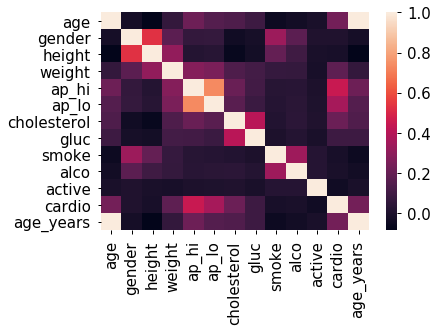

In [49]:
sns.heatmap(corrPearson, 
            xticklabels=corrPearson.columns.values,
            yticklabels=corrPearson.columns.values)

### 3.1 Какие признаки теперь больше всего коррелируют (по Спирмену) друг с другом?


* Height, Weight
* Age, Weight
* Ap_hi, Ap_lo
* Cholesterol, Gluc
* Cardio, Cholesterol
* Smoke, Alco

In [57]:
all_features = [corrPearson.height.weight, corrPearson.age.weight, corrPearson.ap_hi.ap_lo, corrPearson.cholesterol.gluc, 
        corrPearson.cardio.cholesterol, corrPearson.smoke.alco]
print(all_features.index(max(all_features)), max(all_features))

2 0.7354361051379777


Ap_hi, Ap_lo

### 3.2 Почему мы получили такое большое (относительно) значение ранговой корреляции у этих признаков?


* Неточности в данных (ошибки при сборе данных)
* Связь ошибочна, переменные никак не должны быть связаны друг с другом
* Природа данных

Природа данных, т.к. коэффициент ранговой корреляции указывает на связь между признаками, а систолическое и диастолическое давление имеют прямую связь. 

# 4. Совместное распределение признаков


Постройте совместный график распределения jointplot двух наиболее коррелирующих между собой признаков (по Спирмену).

Кажется, наш график получился неинформативным из-за выбросов в значениях. Постройте тот же график, но с логарифмической шкалой (чтобы не получать OverflowError необходимо отфильтровать значения меньше либо равные нулю).

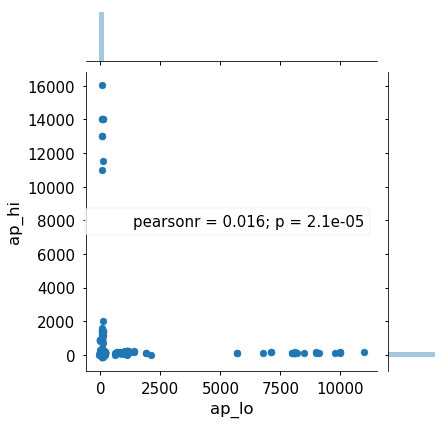

In [63]:
g = sns.jointplot(x="ap_lo", y="ap_hi", data=train)

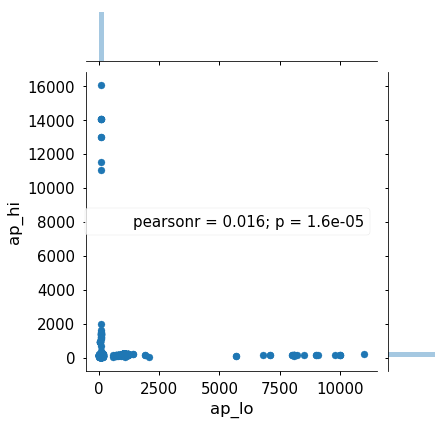

In [4]:
sns.jointplot(x="ap_lo", y="ap_hi", data=train[(train['ap_lo']>0) & (train['ap_hi']>0)])

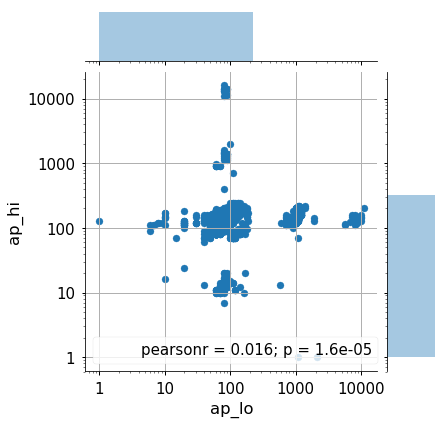

In [19]:
new_data = train[(train['ap_lo']>0) & (train['ap_hi']>0)]
g = sns.jointplot(x="ap_lo", y="ap_hi", data=new_data)
ax = g.ax_joint
ax.set_xscale('log')
ax.set_yscale('log')
"""Сетка"""
g.ax_joint.grid(True) 

"""Преобразуем логарифмические значения на шкалах в реальные"""
ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(x),0)))).format(x)))


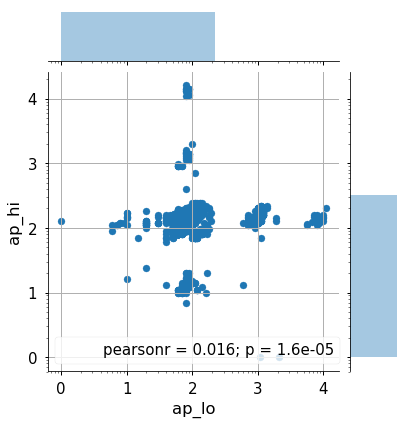

In [20]:
new_data = train[(train['ap_lo']>0) & (train['ap_hi']>0)]
g = sns.jointplot(x="ap_lo", y="ap_hi", data=new_data)
ax = g.ax_joint
ax.set_xscale('log')
ax.set_yscale('log')
"""Сетка"""
g.ax_joint.grid(True) 

"""Преобразуем логарифмические значения на шкалах в реальные"""

ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda y,pos: int(np.minimum(np.exp(y),np.log10(y)))))
ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x,pos: int(np.minimum(np.exp(x),np.log10(x)))))


### 4.1 Сколько чётко выраженных кластеров получилось на совместном графике выбранных признаков, с логарифмической шкалой? Под кластером в данной задаче понимается плотное скопление точек, в окрестности которого пренебрежительно мало одиночных наблюдений и которое визуально отделимо от других кластеров.


* 1
* 2
* 3
* больше трёх

больше трех

# 5. Возраст


Посчитаем, сколько полных лет было респондентам на момент их занесения в базу.

In [9]:
train['age_years'] = (train['age'] // 365.25).astype(int)

Постройте Countplot, где на оси абсцисс будет отмечен возраст, на оси ординат – количество. Каждое значение возраста должно иметь два столбца, соответствующих количеству человек каждого класса **cardio** (здоров/болен) данного возраста.

### 5. В каком возрасте количество пациентов с ССЗ впервые становится больше, чем здоровых?


* 44
* 49
* 53
* 62

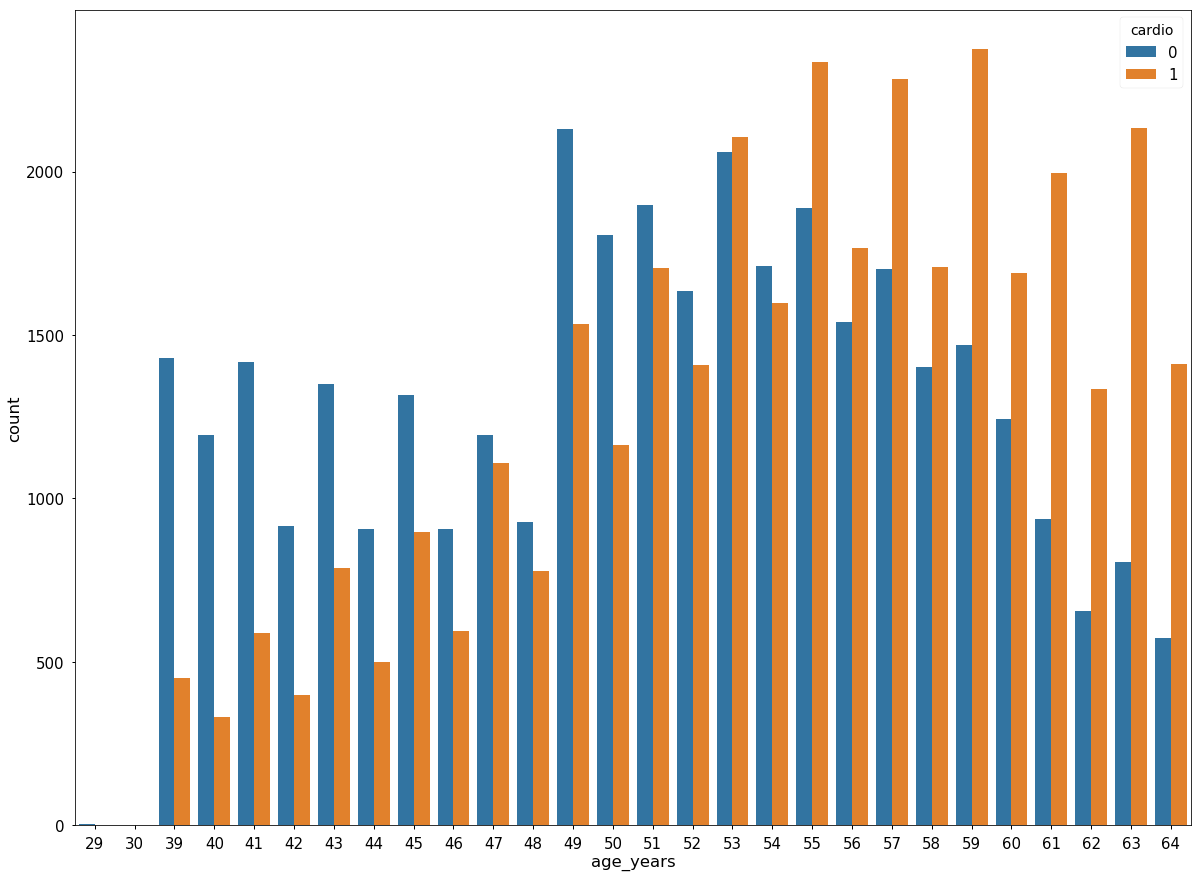

In [68]:
plt.subplots(figsize=(20,15))
sns.countplot(x="age_years", hue="cardio", data=train)

53